In [4]:
!pip install pytorch-lightning
!pip install pytorch-gradcam

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import CSVLogger
from torchvision import datasets, transforms
from datasets import AlbumDataset
from augmentations import train_set_transforms, test_set_transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import albumentations as A
import os
from torchmetrics import Accuracy

# Model

In [5]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class cifar_Lit(LightningModule):
    def __init__(self, block, num_blocks=[2,2,2,2], num_classes=10):
        super(cifar_Lit, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

        BATCH_SIZE = 1024 if torch.cuda.is_available() else 64

        self.dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

        self.accuracy = Accuracy(num_classes=10, task='multiclass')

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        train_loss = nn.CrossEntropyLoss()(output, y)

        correct = output.argmax(dim=1).eq(y).sum().item()
        total=len(y)
        preds = torch.argmax(output, dim=1)
        self.accuracy(preds, y)
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("train_loss", train_loss, prog_bar=True)
        self.log("train_acc", self.accuracy, prog_bar=True)

        return train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        preds = torch.argmax(logits, dim=1)


        self.accuracy(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.accuracy, prog_bar=True)
        return loss


    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        preds = torch.argmax(logits, dim=1)


        self.accuracy(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.accuracy, prog_bar=True)
        return loss #batch_dictionary

        # Here we just reuse the validation_step for testing
        #return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        LEARNING_RATE = 0.03
        WEIGHT_DECAY = 1e-4
        return torch.optim.SGD(self.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=WEIGHT_DECAY)

    def train_dataloader(self):
        train_transforms = A.Compose(train_set_transforms.values())
        train_set = AlbumDataset('./data', train=True, download=True, transform=train_transforms)
        train_loader = torch.utils.data.DataLoader(train_set, **self.dataloader_args)
        return train_loader

    def test_dataloader(self):
        test_transforms = A.Compose(test_set_transforms.values())
        test_set = AlbumDataset('./data', train=False, download=True, transform=test_transforms)
        test_loader = torch.utils.data.DataLoader(test_set, **self.dataloader_args)
        return test_loader

    def val_dataloader(self):
        val_transforms = A.Compose(test_set_transforms.values())
        val_set = AlbumDataset('./data', train=False, download=True, transform=val_transforms)
        val_loader = torch.utils.data.DataLoader(val_set, **self.dataloader_args)
        return val_loader



In [6]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# init the model
cifar10_model = cifar_Lit(BasicBlock)

# init Dataloader from Dataloader
train_loader = cifar10_model.train_dataloader()
test_loader = cifar10_model.test_dataloader()


# initialize the trainer
trainer = Trainer(
    max_epochs = 30,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    logger=CSVLogger(save_dir="logs/"),
    log_every_n_steps=1,
)

# Train the model
trainer.fit(cifar10_model, train_loader)
#trainer.test()



CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params
------------------------------------------------
0 | conv1    | Conv2d             | 1.7 K 
1 | bn1      | BatchNorm2d        | 128   
2 | layer1   | Sequential         | 147 K 
3 | layer2   | Sequential         | 525 K 
4 | layer3   | Sequential         | 2.1 M 
5 | layer4   | Sequential         | 8.4 M 
6 | linear   | Linear             | 5.1 K 
7 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [7]:
torch.save(cifar10_model, 'cifar10_model.pth')


In [8]:
trainer.test()


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/lightning_logs/version_0/checkpoints/epoch=29-step=1470.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/lightning_logs/version_0/checkpoints/epoch=29-step=1470.ckpt


Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8312000036239624     │
│         test_loss         │    0.7691705226898193     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7691705226898193, 'test_acc': 0.8312000036239624}]

,test_acc,test_loss,train_acc,train_loss,val_acc,val_loss
epoch,,,,,,
0,NaN,NaN,0.116211,2.404162,NaN,NaN
0,NaN,NaN,0.169922,2.236467,NaN,NaN
0,NaN,NaN,0.169922,2.256341,NaN,NaN
0,NaN,NaN,0.235352,2.124566,NaN,NaN
0,NaN,NaN,0.226562,2.009024,NaN,NaN


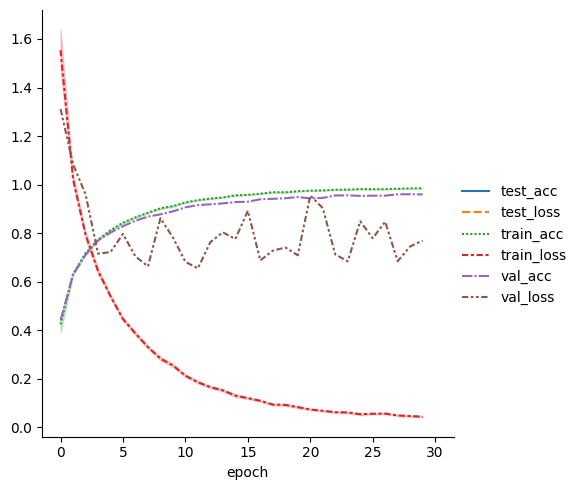

In [14]:
import pandas as pd
import seaborn as sn

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")
